In [1]:
%cd NLP_RL_Docker_Version/

/NLP_RL_Docker_Version


In [2]:
!python3 -W ignore ppo.py --model 0 --ease -1

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibilit

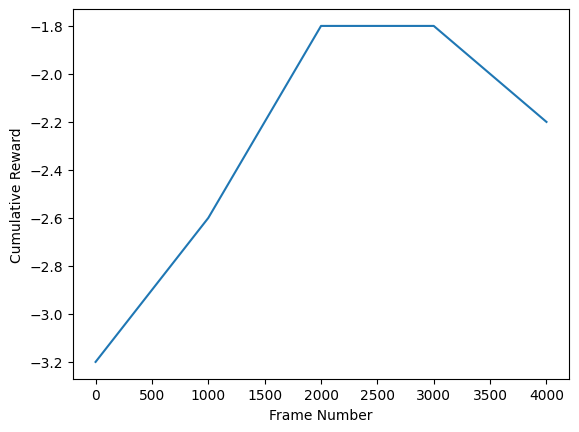

In [7]:
import json 
import matplotlib.pyplot as plt 

arr=[]
with open('results/test_reward_list.json', 'r') as file:
    arr=json.load(file)
    x,y=[arr[i][0] for i in range(len(arr))], [arr[i][1] for i in range(len(arr))]
    plt.plot(x,y)
    plt.xlabel(f'Frame Number')
    plt.ylabel(f'Cumulative Reward')
    plt.show()

In [8]:
import sys 
sys.path.append('/NLP_RL_Docker_Version/gym-examples')
import gym 
import model as M
import utils as U
import torch
import copy
import gym_examples

In [13]:
def run_best_env(number):
    def policy(S):
        dist, value = model(S['visual'])
        action = dist.sample()
        return action.cpu().numpy().item()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model=M.NNModel().to(device)
    model.load_state_dict(torch.load('results/model.ml'))
    dbg=True 
    episodes=1
    env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="rgb_array")
    for _ in range(episodes):
        cumulative_reward,steps=0,0
        observation = env.reset(set_no=number,seed=42)
        state = copy.deepcopy(observation)
        observation['state'] = U.pre_process(observation)
        while True:
            print(observation['text'])
            if dbg==True:
                plt.imshow(state['visual'])
                plt.show()
            action = policy(observation)  # User-defined policy function
            observation, reward, terminated, info = env.step(action)
            print(f'Action {action}')
            state = copy.deepcopy(observation)
            observation['state'] = U.pre_process(observation)
            cumulative_reward+=reward
            steps+=1
            if terminated: break
        print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
    env.close()

This is one. Let's use our blocks to build the number. To build one , pick up the first unit block .


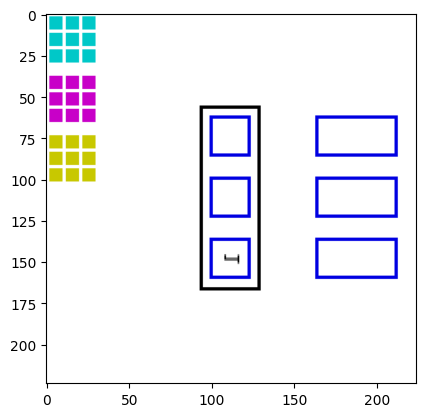

Action 5
This is one. Let's use our blocks to build the number. To build one , pick up the first unit block .


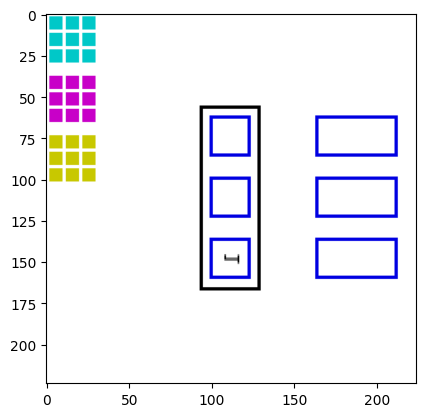

Action 2
Put the unit block in the unit's palce .


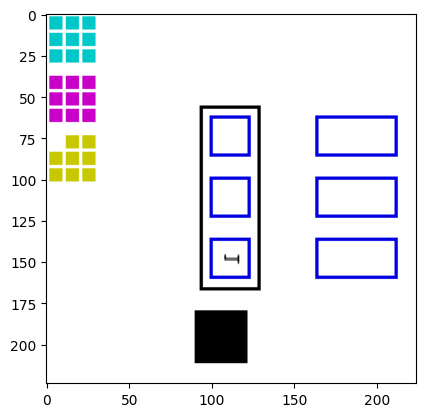

Action 2
Cumulative Reward ~ -11; TimeTaken ~ 3


In [15]:
run_best_env(1)